In [ ]:
# Data availability
##' Time-series transcriptome data of used in this script is available in the NCBI Gene Expression Omnibus 
##' with the accession number of GSE270332.
##' K562 human cell line in RPMI + 10% BCS (bovine calf serum) + P/S
##' source website : https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE270332

In [2]:
# Loading Packages
import numpy as np
import scanpy as sc
import pandas as pd
import decoupler as dc
import subprocess

In [3]:
# import raw data
transcriptome_raw = pd.read_table("../data/GSE270332_k562_timeseries.tsv")
transcriptome_raw

,time_points,0,2,4,6,8,10,12,14,16,...,28,30,32,34,36,38,40,42,44,46
0,ENSG00000100297,89.55440,112.27900,120.07100,116.91100,93.76150,83.71720,73.51850,71.77830,52.977900,...,102.33200,95.33530,82.677700,73.47040,69.41870,66.22850,71.44990,77.17190,72.10020,82.042500
1,ENSG00000111737,33.67870,33.96490,34.59740,43.82600,37.86600,34.52640,33.47520,32.97790,27.893800,...,36.77900,36.76860,37.126200,33.79380,33.67190,33.17470,33.09310,30.38690,29.95750,28.191300
2,ENSG00000148297,10.97540,11.49190,13.18110,15.92540,14.30110,13.62060,10.78080,10.41470,7.406190,...,14.31810,14.38440,11.566700,12.21660,11.10520,10.08040,10.77470,10.92540,10.12760,10.430500
3,ENSG00000105701,93.00610,95.56310,91.36910,100.91600,95.96990,91.28590,90.85310,89.05840,59.848500,...,98.71720,102.14400,98.021700,96.24640,88.68900,86.44870,88.13930,85.72940,90.04630,91.358000
4,ENSG00000197818,3.91415,4.43319,5.50687,4.99821,4.52989,4.36631,3.55905,3.57020,3.304050,...,4.50633,3.93127,4.220080,3.59540,3.69579,3.36569,3.35434,3.49828,3.60724,3.720270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12280,ENSG00000283013,5.83628,6.00153,6.27504,4.87649,4.58706,4.84714,4.31440,5.60865,2.435130,...,5.77533,5.37708,3.937330,4.46126,6.28437,5.13435,4.57600,6.61901,6.16096,6.403760
12281,ENSG00000283023,3.30684,4.95597,4.42905,3.73530,3.86603,3.51884,3.27480,3.34539,4.251510,...,2.67732,2.88747,3.027450,3.97477,3.23287,3.26197,2.69672,2.65821,3.56394,3.071240
12282,ENSG00000283041,3.46199,3.24993,2.81854,2.32530,2.79339,2.55289,3.21661,3.38800,1.162450,...,3.25894,3.25385,2.130910,2.18677,2.79702,2.72033,2.47282,2.48513,2.27583,2.796920
12283,ENSG00000283050,1.74025,2.42216,2.15528,1.70274,1.55680,1.53613,1.81176,1.62393,1.642280,...,1.50250,2.05978,1.885340,1.63446,1.60809,1.48442,1.66574,1.88539,2.24402,1.556810


In [4]:
# データフォーマットを整える
# この処理はデータごとに異なるので各自で修正する
import mygene
df = transcriptome_raw.rename(columns={"time_points": "ensembl_id"})  
# Ensembl ID → Gene Symbol に変換
mg = mygene.MyGeneInfo()
results = mg.querymany(df["ensembl_id"].tolist(),
                       scopes="ensembl.gene",
                       fields="symbol",
                       species="human")
map_df = pd.DataFrame(results)[["query", "symbol"]]
df = df.merge(map_df, left_on="ensembl_id", right_on="query", how="left")
df = df.drop(columns="query").rename(columns={"symbol": "gene_symbol"})
df = df.dropna(subset=["gene_symbol"])
df = df.groupby("gene_symbol").sum(numeric_only=True)
df


querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-12285...done.
Finished.
1 input query terms found dup hits:
	[('ENSG00000278932', 3)]
214 input query terms found no hit:
	['ENSG00000267896', 'ENSG00000250400', 'ENSG00000130723', 'ENSG00000248103', 'ENSG00000272993', 'ENS
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


,0,2,4,6,8,10,12,14,16,18,...,28,30,32,34,36,38,40,42,44,46
gene_symbol,,,,,,,,,,,,,,,,,,,,,
7SK,5.98065,6.11505,9.65210,7.981330,10.757000,11.56310,7.31086,10.02990,6.916020,10.325100,...,1.458200,3.91163,5.98145,6.25282,6.40677,5.75252,7.20874,6.07641,6.25360,26.542900
A1BG,2.56841,2.97777,3.11714,1.465890,1.865050,2.61019,1.92735,1.73854,0.539188,0.178983,...,1.843760,2.59564,2.39676,2.81154,3.44170,3.32603,3.32796,3.71619,3.54308,3.531030
A1BG-AS1,1.20302,1.13011,2.05113,1.325590,1.307360,1.22198,1.49377,1.51476,1.031690,1.023800,...,1.749600,1.50393,1.30041,1.74945,1.67969,1.35156,1.31586,1.64721,1.53177,1.514130
AAAS,54.13820,71.55640,67.61290,92.491300,70.797600,72.96250,66.76870,62.19630,70.749200,63.991400,...,50.159300,47.16350,60.47160,54.17890,45.04680,46.15910,45.88310,44.52080,43.31700,51.982300
AACS,3.59843,3.80771,3.42496,3.954570,3.799670,3.77962,3.30167,3.91678,2.409270,3.034240,...,6.044210,5.68689,4.85886,5.54650,4.98244,5.67251,5.93468,5.52658,5.41401,5.034300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,8.31121,7.27806,8.79881,7.014250,8.056830,8.06953,8.32515,8.29926,10.929000,11.421100,...,9.007850,8.11187,8.37865,8.29881,8.86345,9.01288,9.39868,8.89768,9.08808,9.121220
ZYX,41.34110,48.42240,49.70430,81.549800,41.643500,36.67870,31.96900,32.49980,56.208300,52.182100,...,46.613900,43.83300,90.08100,55.50320,43.60300,42.81410,47.29550,47.81420,46.78080,51.649300
ZZEF1,5.97939,6.48600,5.93625,7.293720,6.130440,4.93886,5.01184,4.53384,4.258100,4.712930,...,5.837000,5.16895,5.75013,5.76472,5.94003,4.88588,4.84172,4.73421,4.85647,4.997480


In [5]:
# calculate z score
expr_z = df.sub(df.mean(axis=1), axis=0).div(df.std(axis=1), axis=0) # (値 - 行平均) / 行標準偏差
expr_z = expr_z.dropna(how="any") # NaNを含む行を削除
expr_z

,0,2,4,6,8,10,12,14,16,18,...,28,30,32,34,36,38,40,42,44,46
gene_symbol,,,,,,,,,,,,,,,,,,,,,
7SK,-0.322570,-0.294559,0.442621,0.094405,0.672901,0.840905,-0.045332,0.521361,-0.127623,0.582886,...,-1.265124,-0.753788,-0.322403,-0.265845,-0.233759,-0.370116,-0.066616,-0.302612,-0.265683,3.962945
A1BG,0.147009,0.590761,0.741840,-1.048139,-0.615444,0.192299,-0.547910,-0.752583,-2.052698,-2.443166,...,-0.638523,0.176526,-0.039063,0.410565,1.093668,0.968280,0.970372,1.391219,1.203565,1.190503
A1BG-AS1,-1.029655,-1.304395,2.166204,-0.567785,-0.636479,-0.958209,0.065953,0.145048,-1.675262,-1.704994,...,1.029975,0.104238,-0.662668,1.029410,0.766539,-0.469924,-0.604450,0.644148,0.209145,0.142674
AAAS,-0.310045,1.121147,0.797124,2.841294,1.058799,1.236681,0.727759,0.352061,1.054822,0.499558,...,-0.636977,-0.883131,0.210348,-0.306701,-1.057053,-0.965659,-0.988337,-1.100273,-1.199185,-0.487188
AACS,-0.937153,-0.737045,-1.103020,-0.596621,-0.744732,-0.763904,-1.220907,-0.632755,-2.074197,-1.476617,...,1.401439,1.059779,0.268038,0.925542,0.386202,1.046029,1.296709,0.906495,0.798858,0.435789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,-0.451919,-1.486788,0.036493,-1.751036,-0.706722,-0.694001,-0.437955,-0.463888,2.170227,2.663146,...,0.245880,-0.651590,-0.384366,-0.464339,0.101240,0.250919,0.637361,0.135527,0.326244,0.359439
ZYX,-0.495431,0.027475,0.122135,2.473709,-0.473101,-0.839718,-1.187497,-1.148301,0.602411,0.305103,...,-0.106071,-0.311421,3.103680,0.550344,-0.328405,-0.386660,-0.055739,-0.017437,-0.093746,0.265760
ZZEF1,0.842171,1.561493,0.780918,2.708353,1.056643,-0.635249,-0.531627,-1.210326,-1.601842,-0.956041,...,0.639995,-0.308551,0.516651,0.537367,0.786285,-0.710474,-0.773176,-0.925826,-0.752233,-0.552016


In [6]:
# obs
obs = pd.DataFrame(index=expr_z.columns)  
obs.index.name = "sample"  
obs["time"] = obs.index.astype(int)
# expr_z は gene_symbol を行、time を列に持つデータフレーム
X = expr_z.T.values  # AnnData の構造に合わせるために転置
# var
var = pd.DataFrame(index=expr_z.index)  
var.index.name = "gene_symbol"
# AnnData 
adata = sc.AnnData(X=X, obs=obs, var=var)

In [7]:
# Import net
subprocess.run(["Rscript", "get_collectri.R"], check=True)
collectri = pd.read_csv('../data/collectri.csv')
collectri


次のパッケージを付け加えます: ‘dplyr’

以下のオブジェクトは ‘package:stats’ からマスクされています:

    filter, lag

以下のオブジェクトは ‘package:base’ からマスクされています:

    intersect, setdiff, setequal, union

[2025-09-11 14:17:17] [SUCCESS] [OmnipathR] Loaded 64958 interactions from cache.
[2025-09-11 14:17:18] [SUCCESS] [OmnipathR] Downloaded 232 interactions.
警告メッセージ:
OmnipathR::import_tf_mirna_interactions(genesymbols = TRUE, resources = "CollecTRI",  で:
  'OmnipathR::import_tf_mirna_interactions' は廃止予定です
'tf_mirna' を代わりに使って下さい
help("Deprecated") を見て下さい


,source,target,weight
0,MYC,TERT,1
1,SPI1,BGLAP,1
2,SMAD3,JUN,1
3,SMAD4,JUN,1
4,STAT5A,IL2,1
...,...,...,...
43173,NFKB,hsa-miR-143-3p,1
43174,AP1,hsa-miR-206,1
43175,NFKB,hsa-miR-21-5p,1
43176,NFKB,hsa-miR-224-5p,1


In [8]:
# ===== run ULM =====
dc.mt.ulm(data=adata, net=collectri, tmin=3)
score = adata.obsm["score_ulm"]
score_df = pd.DataFrame(score)
decoupleR_TF = score_df.T
# save TF activities
decoupleR_TF.to_csv('../results/tables/decoupleR_TF.csv', index=True)
decoupleR_TF

sample,0,2,4,6,8,10,12,14,16,18,...,28,30,32,34,36,38,40,42,44,46
ABL1,1.747746,-0.125555,-2.003987,-0.389569,0.623944,-0.635411,-0.161983,-0.234865,-1.441488,-1.603175,...,-0.069751,0.884389,-0.087322,1.759129,1.090469,0.529207,0.895439,1.348176,2.994437,3.715053
AHR,1.615153,0.510233,-0.105646,1.016298,1.250899,1.547009,1.091771,1.964158,0.097759,-0.322876,...,-1.565563,-0.164956,-1.119186,0.064519,-0.596693,-0.879244,-0.406101,0.191165,0.376625,0.841400
AHRR,-0.879425,-0.128779,1.058416,1.298061,1.752839,1.602679,2.596884,1.260837,-0.688831,-0.891574,...,-0.459712,0.012847,-0.289576,0.367887,0.288007,-1.433420,-1.660186,-1.197998,0.066245,-0.126159
AIRE,1.715858,1.091545,-0.103884,1.300924,0.530623,0.175631,0.425272,0.199687,1.234835,0.243197,...,-0.667140,-1.148975,1.181178,-1.306720,-1.315425,-0.371512,-1.229556,-1.430286,-1.413206,-1.108836
ALX1,1.466337,0.301734,-0.072219,0.810094,0.326203,0.251211,-0.156032,-0.675542,0.818007,0.466115,...,-0.767317,-1.033920,0.761179,0.151360,-0.625651,-0.549687,-0.142149,-0.589164,-0.771356,-0.477708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF451,0.137341,-0.517732,0.562704,0.277812,-0.082505,-0.678870,0.735118,-0.258752,-1.742135,-1.829597,...,0.186212,0.530049,1.420026,0.809004,1.087172,0.914610,1.748089,1.359833,0.726222,-0.760136
ZNF699,-0.581644,0.003826,-0.587990,-0.133613,0.171843,0.518987,-0.162542,1.262970,-0.063037,-0.595624,...,0.174515,0.660494,-0.303131,0.573552,1.586932,-0.282872,0.373488,0.285305,-0.329082,0.178650
ZNF76,0.706319,-0.412225,-0.573695,0.353137,-0.462810,0.612310,0.662490,0.271881,-0.343738,0.471907,...,0.972762,0.659782,0.798634,0.132590,-1.871279,-0.240411,-0.766142,-2.294513,-1.002934,-0.464550
ZNF804A,1.423563,-0.161270,0.378701,0.708611,0.660971,0.751260,0.715852,0.426910,-0.980064,-0.913344,...,-1.074455,-0.222416,-0.241591,-0.439126,-0.304008,-0.477082,-0.955379,-0.230935,0.917555,3.715428


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
警告メッセージ:
1: パッケージ ‘ggplot2’ はバージョン 4.4.1 の R の下で造られました 
2: パッケージ ‘purrr’ はバージョン 4.4.1 の R の下で造られました 
3: パッケージ ‘lubridate’ はバージョン 4.4.1 の R の下で造られました 


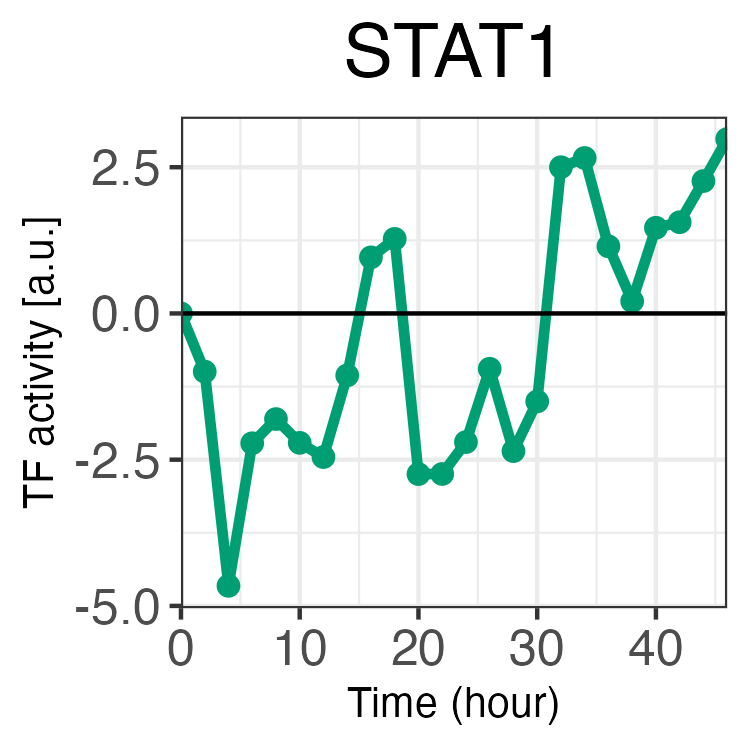

In [9]:
# draw lineplots 
subprocess.run(["Rscript", "TF_lineplot.R"], check=True)

# show one of the result figs
from IPython.display import Image, display
display(Image(filename="../results/figures/TF_lineplot/STAT1.png"))